In [9]:
import joblib
from pathlib import Path
import argparse
import os
import datetime
from dataset.bbox_dataset import get_datasets, get_kfold_dataset
from dataset.create_kfolds import create_kfolds
from models.bbox_dispatcher import create_model
from metrices.iou import IoU
from train_bbox import __get_callbacks__

import tensorflow as tf

import tensorflow as tf

import os
import datetime

from PIL import Image
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
dataset_path = '../fyp/ccpd_sample/content/home/booy/booy/ccpd_dataset/ccpd_base/'
folds = 5

In [3]:
fold_data = create_kfolds(Path(dataset_path), folds)
fold = 0

dataset directory:../fyp/ccpd_sample/content/home/booy/booy/ccpd_dataset/ccpd_base
number of files: 9999 fold size : 1999


In [4]:
model_name = 'v16'
input_shape = target_size = (480,480)
BATCH_SIZE = 32

In [5]:
model = create_model(model_name, input_shape + (3, ))
train_dataset, test_dataset = get_kfold_dataset(fold_data, fold, input_shape, BATCH_SIZE)


In [6]:
def plot_image(dataset,idx=0):
  images, Y = next(iter(dataset))
  image = images[1]
  y = Y[1]
  image = (image.numpy()*255).astype(np.uint8)
  y = (y.numpy()*target_size[0]).astype(int)

  plt.imshow(image, interpolation='nearest')
  # Get the current reference
  ax = plt.gca()
  x_center, y_center, w, h = y
  x1 = x_center - (w/2)
  y1 = y_center - (h/2)

  # Create a Rectangle patch
  rect = Rectangle((x1,y1),w,h,linewidth=1,edgecolor='r',facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)
  plt.show()


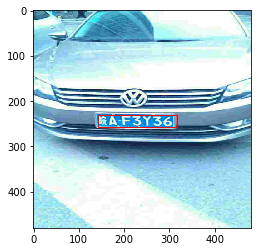

In [7]:
plot_image(train_dataset)

In [19]:
def __get_paths__(model_name):
    log_dir = f"logs/simple_bbox/{model_name}/" + datetime.datetime.now(
    ).strftime("%y%m%d-%h%m%s")
    checkpoint_dir = f"checkpoints/{model_name}"
    return log_dir, checkpoint_dir


def __get_callbacks__(model_name):
    log_dir, checkpoint_dir = __get_paths__(model_name)

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=1)
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir, save_weights_only=True, monitor='val_loss')
    return [
        tensorboard_callback, model_checkpoint_callback
    ]



In [ ]:
callbacks = __get_callbacks__(model_name)
model.fit(train_dataset,
      validation_data=test_dataset,
      callbacks=[callbacks],
      epochs=60)


Epoch 1/60
  1/250 [..............................] - ETA: 2s - loss: 0.1463WARNING:tensorflow:From /home/heshan/anaconda3/envs/fyp/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
250/250 [==============================] - 1476s 6s/step - loss: 0.0061 - val_loss: 0.0548
Epoch 2/60
250/250 [==============================] - 1501s 6s/step - loss: 0.0036 - val_loss: 0.0378
Epoch 3/60
